# **Wine Quality**

https://archive.ics.uci.edu/dataset/186/wine+quality

## **1. Chuẩn bị dữ liệu**

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

- Config

In [2]:
class CONFIG:
    # Giá trị ngẫu nhiên
    random_state = None

    # Tỷ lệ chia tập dữ liệu
    split_ratios = {
        '40/60': 0.4,
        '60/40': 0.6,
        '80/20': 0.8,
        '90/10': 0.9
    }

    # Giá trị mặc định để kiểm tra độ sâu và độ chính xác
    default_split = '80/20'

    # Đường dẫn file dữ liệu gốc
    raw_data_path = "Raw/winequality-white.csv"

    # Thư mục lưu kết quả các phân phối
    distribution_dataset_dir = "Results/DistributedDataset"

    # Thư mục lưu kết quả cây quyết định với các tỉ lệ
    tree_visual_split_dir = "Results/TreeVisualizationsBySplit"

    # Thư mục lưu kết quả thử nghiệm max_depth cho cây quyết định
    tree_visual_max_depth_dir = "Results/TreeVisualizationsWithMaxDepth"

    # Thư mục lưu kết quả trực quan hóa
    visual_confusion_matrix_dir = "Results/VisualizationConfusionMatrix"

    # Giá trị độ sâu tối đa cho thử nghiệm cây quyết định
    max_depth_values = [None, 2, 3, 4, 5, 6, 7]

#### **1. Đọc dữ liệu**

In [3]:
# Đọc dữ liệu rượu trắng
data = pd.read_csv(CONFIG.raw_data_path, delimiter=';')
#(R) data['wine_type'] = 'white'  # Thêm cột phân loại loại rượu

In [4]:
# Đọc dữ liệu rượu đỏ
#data_red = pd.read_csv(CONFIG.RAW_DATA_PATH_RED, delimiter=';')
#(R) data_red['wine_type'] = 'red'  # Thêm cột phân loại loại rượu

# Ghép hai dữ liệu
#data = pd.concat([data_white, data_red], axis=0, ignore_index=True)

In [5]:
# Thêm cột "Quality_Category" để nhóm chất lượng
# 0-4: Chất lượng thấp, 5-6: Tiêu chuẩn, 7-10: Chất lượng cao
class_name = 'Quality_Category'
data[class_name] = pd.cut(
    data['quality'],
    bins=[-1, 4, 6, 10],
    labels=['Low', 'Standard', 'High']
)

- Kiểm tra dữ liệu

In [6]:
# Kiểm tra thông tin dữ liệu
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         4898 non-null   float64 
 1   volatile acidity      4898 non-null   float64 
 2   citric acid           4898 non-null   float64 
 3   residual sugar        4898 non-null   float64 
 4   chlorides             4898 non-null   float64 
 5   free sulfur dioxide   4898 non-null   float64 
 6   total sulfur dioxide  4898 non-null   float64 
 7   density               4898 non-null   float64 
 8   pH                    4898 non-null   float64 
 9   sulphates             4898 non-null   float64 
 10  alcohol               4898 non-null   float64 
 11  quality               4898 non-null   int64   
 12  Quality_Category      4898 non-null   category
dtypes: category(1), float64(11), int64(1)
memory usage: 464.2 KB
None


In [7]:

# Kiểm tra sơ bộ
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality Quality_Category  
0      8.8        6         Standard  
1      9

In [8]:
# Kiểm tra giá trị duy nhất trong nhãn:
print(data['Quality_Category'].value_counts())

Quality_Category
Standard    3655
High        1060
Low          183
Name: count, dtype: int64


In [9]:
# Kiểm tra thống kê dữ liệu:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

#### **2. Tiền xử lý dữ liệu**

- Loại bỏ cột "quality" (không cần thiết)

In [10]:
data = data.drop(columns=['quality'])

- Mã hóa cột **class**

In [11]:
# Mã hóa cột class
encoder = LabelEncoder()
data[class_name] = encoder.fit_transform(data[class_name])

# Thứ tự các nhãn để trực quan hóa
class_order = encoder.classes_

- Xáo trộn dữ liệu

In [12]:
data = shuffle(data, random_state=CONFIG.random_state)

- Tách nhãn và đặc trưng

In [13]:
X = data.drop(columns=[class_name])

y = data[class_name]

#### **3. Phân chia dữ liệu với các tỷ lệ khác nhau**

In [14]:
datasets = {}
for split_name, train_ratio in CONFIG.split_ratios.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=CONFIG.random_state
    )
    datasets[split_name] = {
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test,
    }

#### **4. Hình dung phân phối nhãn**

In [15]:
def plot_label_distribution(y, title, img_path):
    y_decoded = encoder.inverse_transform(y)
    sns.countplot(x=y_decoded,order=class_order)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
    plt.savefig(img_path)
    print(f"* save as {img_path}")

- Phân phối dữ liệu gốc

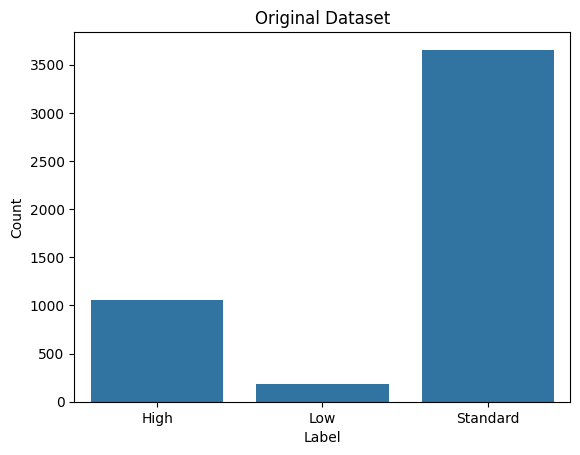

* save as Results/DistributedDataset/origin.png


<Figure size 640x480 with 0 Axes>

In [16]:
img_path = f"{CONFIG.distribution_dataset_dir}/origin.png"
plot_label_distribution(y, 'Original Dataset',img_path)

- Phân phối các tập con

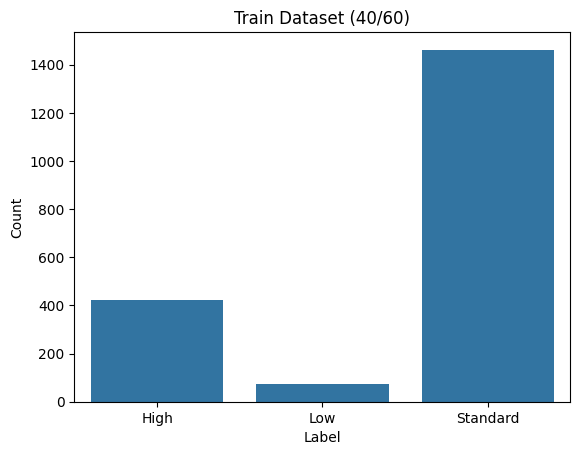

* save as Results/DistributedDataset/40_60_train.png


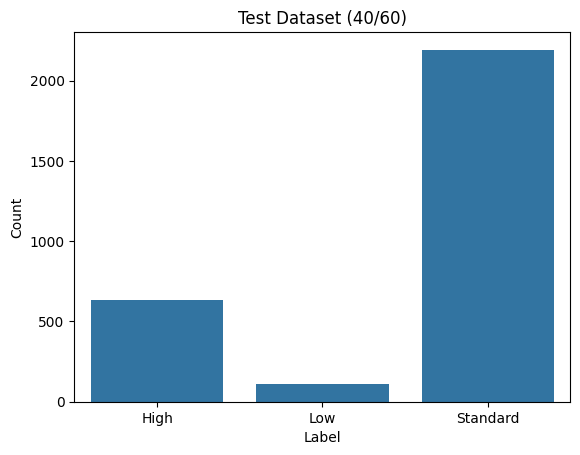

* save as Results/DistributedDataset/40_60_test.png


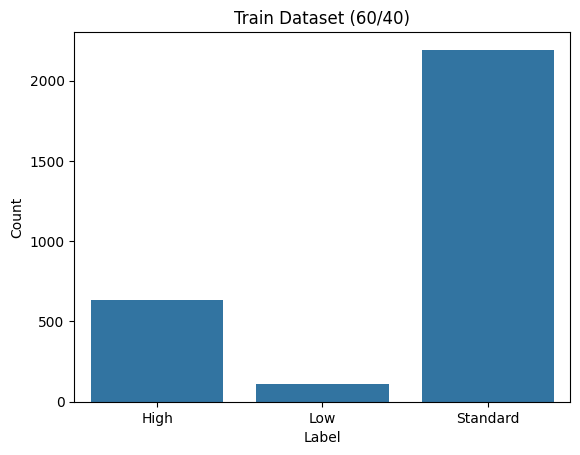

* save as Results/DistributedDataset/60_40_train.png


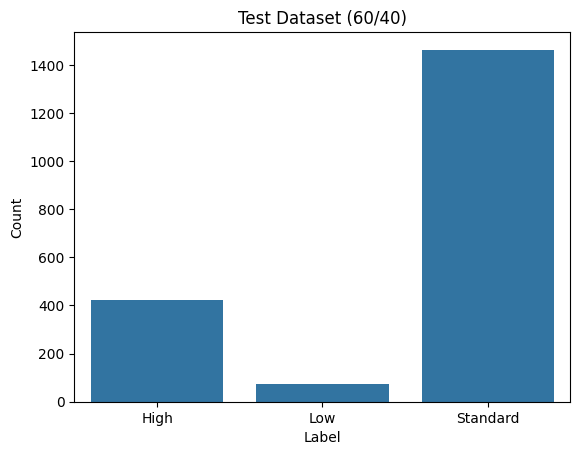

* save as Results/DistributedDataset/60_40_test.png


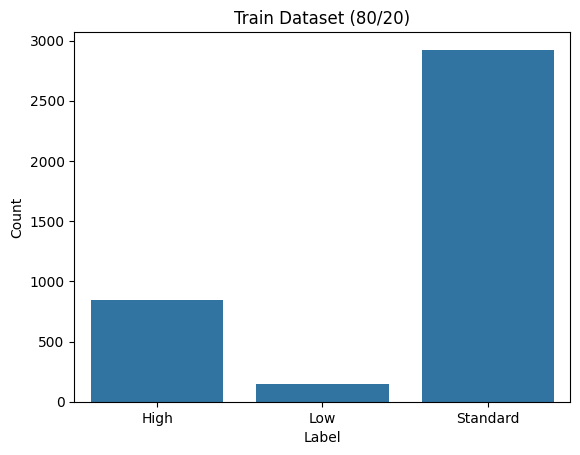

* save as Results/DistributedDataset/80_20_train.png


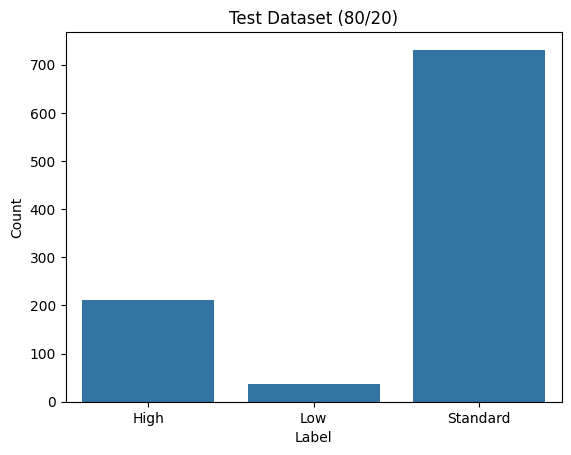

* save as Results/DistributedDataset/80_20_test.png


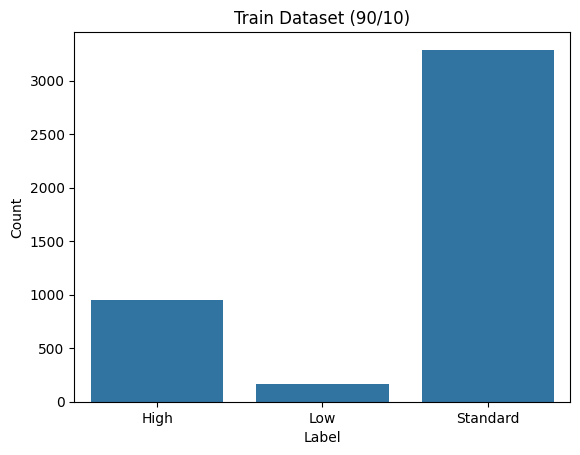

* save as Results/DistributedDataset/90_10_train.png


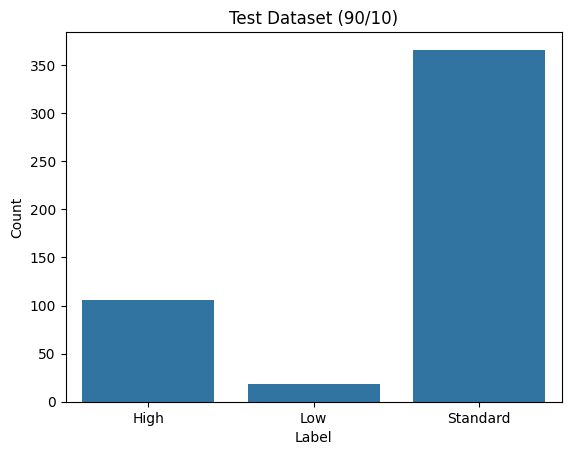

* save as Results/DistributedDataset/90_10_test.png


<Figure size 640x480 with 0 Axes>

In [17]:
for split_name, dataset in datasets.items():
    dir_path = f"{CONFIG.distribution_dataset_dir}/{split_name.replace('/','_')}"
    plot_label_distribution(dataset['label_train'], f'Train Dataset ({split_name})', f'{dir_path}_train.png')
    plot_label_distribution(dataset['label_test'], f'Test Dataset ({split_name})', f'{dir_path}_test.png')

## **2. Xây dựng bộ phân loại**

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import graphviz

- Hàm huấn luyện và trực quan hóa cây quyết định

In [19]:
def train_and_visualize(features_train, labels_train, features_test, labels_test, split_name):
    # Huấn luyện cây quyết định
    model = DecisionTreeClassifier(criterion='entropy', random_state=CONFIG.random_state)
    model.fit(features_train, labels_train)
    
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    
    # Giải mã để xem báo cáo
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)

    # Dự đoán và đánh giá mô hình
    print(f"Results for split {split_name}")
    print("- Classification Report:")
    print(classification_report(labels_test_decoded, predictions_decoded))

    print(f"- Accuracy: {accuracy:.6f}")
    
    # Trực quan hóa cây quyết định
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=features_train.columns,
        class_names=class_order,
        filled=True, rounded=True, special_characters=True
    )
    graph = graphviz.Source(dot_data)
    filepath = f"{CONFIG.tree_visual_split_dir}/{split_name.replace('/', '_')}"
    graph.render(filepath, format="pdf")
    # graph.view()  # Mở cây trực tiếp
    # display(graph)
    print(f"- Saved tree visualization for {filepath}.pdf")
    print("------------------------------------------\n")

- Huấn luyện và trực quan hóa với từng tập con

In [20]:
for split_name, dataset in datasets.items():
    train_and_visualize(
        features_train=dataset['feature_train'],
        labels_train=dataset['label_train'],
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        split_name=split_name
    )

Results for split 40/60
- Classification Report:
              precision    recall  f1-score   support

        High       0.54      0.54      0.54       636
         Low       0.31      0.35      0.33       110
    Standard       0.84      0.84      0.84      2193

    accuracy                           0.75      2939
   macro avg       0.56      0.57      0.57      2939
weighted avg       0.76      0.75      0.76      2939

- Accuracy: 0.753998
- Saved tree visualization for Results/TreeVisualizationsBySplit/40_60.pdf
------------------------------------------

Results for split 60/40
- Classification Report:
              precision    recall  f1-score   support

        High       0.56      0.60      0.58       424
         Low       0.29      0.26      0.27        73
    Standard       0.85      0.84      0.84      1463

    accuracy                           0.76      1960
   macro avg       0.57      0.57      0.56      1960
weighted avg       0.77      0.76      0.77      1960



## **3. Đánh giá các bộ phân loại**

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

- Hàm đánh giá mô hình và tạo báo cáo

In [22]:
def evaluate_model(features_test, labels_test, model, split_name):
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)

    # Chuyển ngược về nhãn
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)
    
    # Classification Report
    print("------------------------------------------\n")
    print(f"- Classification Report for split {split_name}")
    print(classification_report(labels_test_decoded, predictions_decoded))

    # Confusion Matrix
    cm = confusion_matrix(labels_test, predictions)
    print(f"- Confusion Matrix for split {split_name}:\n{cm}\n")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_order, yticklabels=class_order)
    plt.title(f"Confusion Matrix for {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    visual_path = f"{CONFIG.visual_confusion_matrix_dir}/{split_name.replace('/', '_')}.png"
    plt.savefig(visual_path)
    print(f"- Saved as: {visual_path}")
    plt.show()

    # Trả về mô hình và độ chính xác
    accuracy = accuracy_score(labels_test, predictions)
    return accuracy

- Lặp qua từng tập con để huấn luyện, đánh giá, và lưu kết quả

------------------------------------------

- Classification Report for split 40/60
              precision    recall  f1-score   support

        High       0.53      0.54      0.53       636
         Low       0.31      0.34      0.32       110
    Standard       0.84      0.83      0.83      2193

    accuracy                           0.75      2939
   macro avg       0.56      0.57      0.56      2939
weighted avg       0.75      0.75      0.75      2939

- Confusion Matrix for split 40/60:
[[ 344    8  284]
 [   7   37   66]
 [ 299   74 1820]]

- Saved as: Results/VisualizationConfusionMatrix/40_60.png


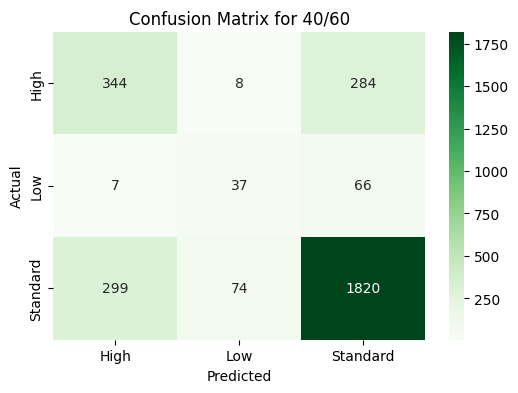

------------------------------------------

- Classification Report for split 60/40
              precision    recall  f1-score   support

        High       0.56      0.60      0.58       424
         Low       0.26      0.26      0.26        73
    Standard       0.85      0.84      0.85      1463

    accuracy                           0.77      1960
   macro avg       0.56      0.57      0.56      1960
weighted avg       0.77      0.77      0.77      1960

- Confusion Matrix for split 60/40:
[[ 255    4  165]
 [  10   19   44]
 [ 187   49 1227]]

- Saved as: Results/VisualizationConfusionMatrix/60_40.png


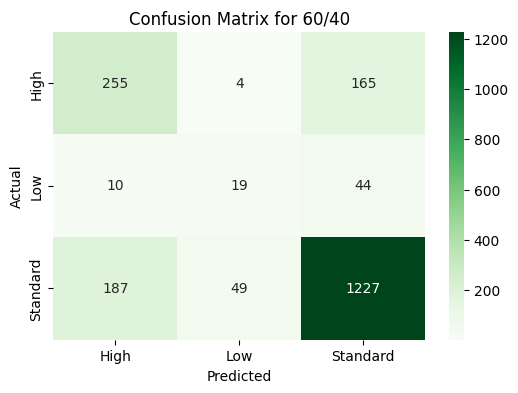

------------------------------------------

- Classification Report for split 80/20
              precision    recall  f1-score   support

        High       0.61      0.61      0.61       212
         Low       0.36      0.32      0.34        37
    Standard       0.86      0.86      0.86       731

    accuracy                           0.79       980
   macro avg       0.61      0.60      0.61       980
weighted avg       0.79      0.79      0.79       980

- Confusion Matrix for split 80/20:
[[130   1  81]
 [  2  12  23]
 [ 80  20 631]]

- Saved as: Results/VisualizationConfusionMatrix/80_20.png


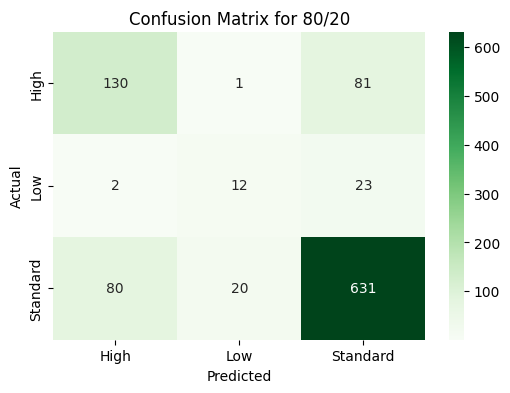

------------------------------------------

- Classification Report for split 90/10
              precision    recall  f1-score   support

        High       0.67      0.64      0.66       106
         Low       0.36      0.28      0.31        18
    Standard       0.87      0.89      0.88       366

    accuracy                           0.81       490
   macro avg       0.63      0.60      0.62       490
weighted avg       0.81      0.81      0.81       490

- Confusion Matrix for split 90/10:
[[ 68   0  38]
 [  2   5  11]
 [ 31   9 326]]

- Saved as: Results/VisualizationConfusionMatrix/90_10.png


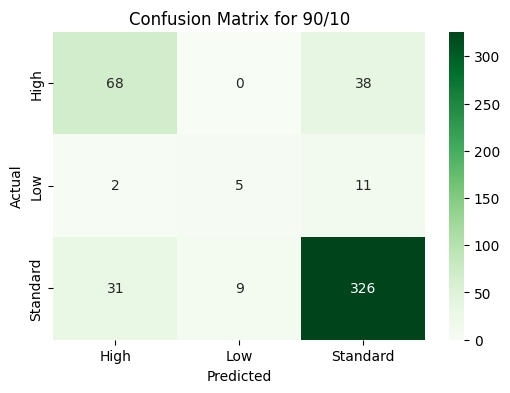

In [23]:
results = {}
for split_name, dataset in datasets.items():
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', random_state=CONFIG.random_state)
    model.fit(dataset['feature_train'], dataset['label_train'])
    
    # Đánh giá mô hình
    accuracy = evaluate_model(
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        model=model,
        split_name=split_name
    )
    
    # Lưu kết quả
    results[split_name] = accuracy

- Hiển thị tổng hợp kết quả độ chính xác

In [24]:
for split_name, accuracy in results.items():
    print(f"Accuracy for {split_name}: {accuracy:.6f}")

Accuracy for 40/60: 0.748894
Accuracy for 60/40: 0.765816
Accuracy for 80/20: 0.788776
Accuracy for 90/10: 0.814286


## **4.Độ sâu và độ chính xác**

- Lấy bộ dữ liệu huấn luyện và kiểm tra 80/20

In [25]:
X_train = datasets[CONFIG.default_split]['feature_train']
y_train = datasets[CONFIG.default_split]['label_train']
X_test  = datasets[CONFIG.default_split]['feature_test']
y_test  = datasets[CONFIG.default_split]['label_test']

- Thử nghiệm với các giá trị max_depth khác nhau

In [26]:
accuracy_scores = {}

for max_depth in CONFIG.max_depth_values:
    # Tạo và huấn luyện cây quyết định với max_depth
    model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=CONFIG.random_state)
    model.fit(X_train, y_train)
    
    # Dự đoán và tính độ chính xác
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[max_depth] = accuracy
    
    # Trực quan hóa cây quyết định
    print(f"Decision Tree with max_depth={max_depth}")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=encoder.classes_,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    path = f"{CONFIG.tree_visual_max_depth_dir}/{'none' if max_depth is None else max_depth}"
    graph.render(path, format="pdf")
    print(f"- Saved tree visualization for {path}.pdf")
    print("------------------------------------------\n")


Decision Tree with max_depth=None
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/none.pdf
------------------------------------------

Decision Tree with max_depth=2
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/2.pdf
------------------------------------------

Decision Tree with max_depth=3
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/3.pdf
------------------------------------------

Decision Tree with max_depth=4
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/4.pdf
------------------------------------------

Decision Tree with max_depth=5
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/5.pdf
------------------------------------------

Decision Tree with max_depth=6
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/6.pdf
------------------------------------------

Decision Tree with max_depth=7
- Saved tree visualization for Results/TreeVisualizations

- Hiển thị bảng kết quả

In [27]:
print("max_depth\tAccuracy")
for max_depth, accuracy in accuracy_scores.items():
    print(f"{'None' if max_depth is None else max_depth}\t\t{accuracy:.6f}")

max_depth	Accuracy
None		0.786735
2		0.745918
3		0.756122
4		0.772449
5		0.777551
6		0.778571
7		0.791837


- Vẽ biểu đồ độ chính xác

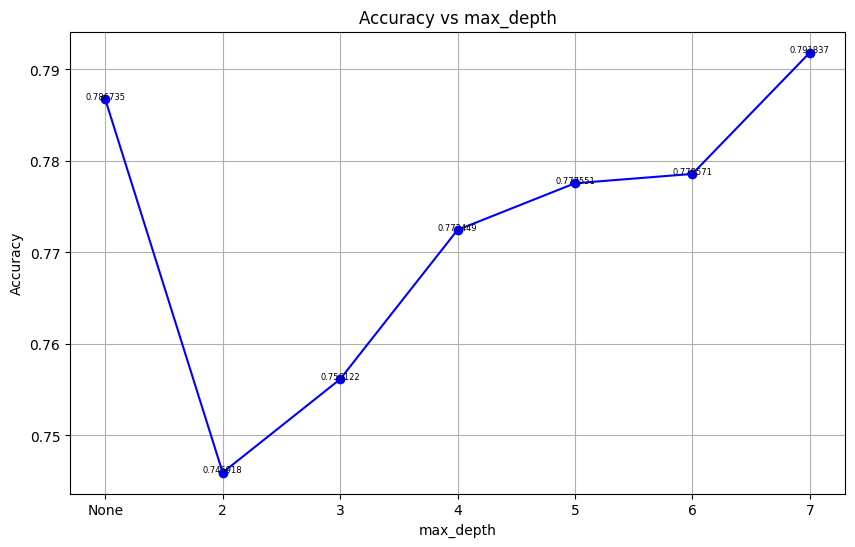

In [28]:
depth_labels = ['None' if d is None else d for d in CONFIG.max_depth_values]
accuracy_values = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.plot(depth_labels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
for i, txt in enumerate(accuracy_values):
    plt.text(i, accuracy_values[i], f"{accuracy_values[i]:.6f}", fontsize=6, ha='center')

plt.show()
